In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [6]:
import pandas as pd

In [4]:

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"

In [7]:

import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark.conf.set("spark.sql.caseSensitive", True) # Avoid error "Found duplicate column(s) in the data schema"
spark

In [5]:
# set up the work environment by "importing" the packages needed.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# apply the default seaborn themes and styles
sns.set()

In [ ]:
CD = spark.read.json('drive/MyDrive/meta_Automotive.json.gz')

Filtering the meta df into only columns needed

In [ ]:
from pyspark.sql.functions import array_contains

# Define the target category
target_category = ["Performance Parts & Accessories","Exhaust System"]

# Filter the original DataFrame
PerfomanceExhaust_df = CD.filter(array_contains(CD.category, target_category[0]) &
                         array_contains(CD.category, target_category[1]))

PerfomanceExhaust_df.show()
PerfomanceExhaust_df_filtered = PerfomanceExhaust_df.select("title","asin","price","rank")


Filtering necessarry columns from review data

In [ ]:
Auto_review = spark.read.json('drive/MyDrive/Colab Notebooks/Automotive_5.json.gz')

In [ ]:
Auto_review_filtered = Auto_review.select("asin","overall","reviewText")

In [ ]:
from pyspark.sql.functions import col


# Inner join on the "asin" column
Final_Exhaust_df = Auto_review_filtered.join(PerfomanceExhaust_df_filtered, ["asin"], "inner")


In [8]:
Finalexhaust = spark.read.json('drive/MyDrive/Colab Notebooks/Final_Exhaust_df.json')

Final filtered data set - 1860 rows

In [9]:
distinct_values = Finalexhaust.select('title').distinct()


In [10]:

distinct_values.count()

135


### <font color=yellow>Panda DF</font>

In [12]:

Finalexhaust_pd_Df = Finalexhaust.toPandas()
type(Finalexhaust_pd_Df)

pandas.core.frame.DataFrame

### <font color=yellow>Overall rating bar chart</font>

<Axes: >

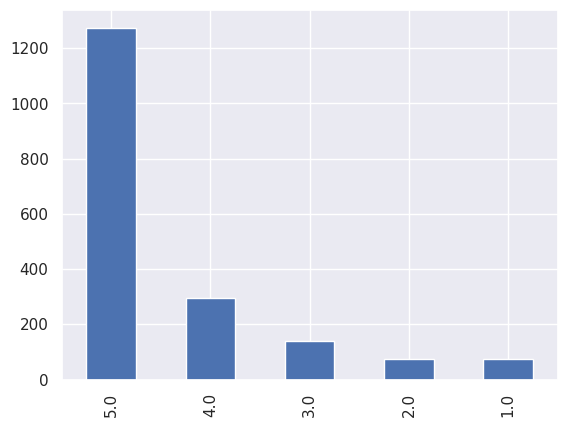

In [13]:
# bar chart for overall ratings

Finalexhaust_pd_Df.overall.value_counts().plot(kind='bar')

In [14]:
Finalexhaust_pd_Df.overall.describe()

count    1860.000000
mean        4.406452
std         1.061509
min         1.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: overall, dtype: float64

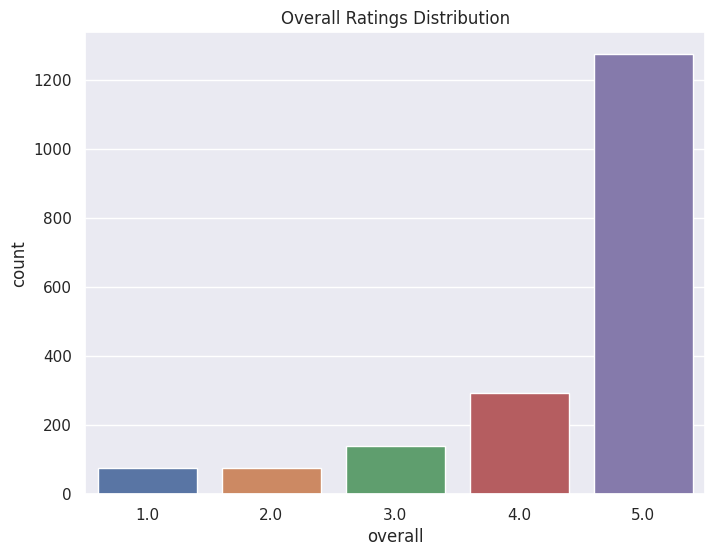

In [15]:
sns.set(style="darkgrid")
plt.figure(figsize=(8, 6))
ax = sns.countplot(x="overall", data=Finalexhaust_pd_Df)
plt.title("Overall Ratings Distribution")
plt.show()

### <font color=yellow>logistic regression</font>

In [16]:
from pyspark.sql import functions as f

# Use nickname feat for the subpackage
import pyspark.ml.feature as feat

# We need Pipeline to streamline the workflow
from pyspark.ml import Pipeline

# Use logistic regression
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier

# Import an evaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


# Additional functions for tuning parameters
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [17]:
myData = Finalexhaust.withColumn(
    "sentiment",
    f.when((f.col("overall")>=4), "positive")
      .when((f.col("overall")==3), "neutral")
      .when((f.col("overall")<=2), "negative")
)
myData.show()

+----------+-------+------+--------------------+--------------------+--------------------+---------+
|      asin|overall| price|                rank|          reviewText|               title|sentiment|
+----------+-------+------+--------------------+--------------------+--------------------+---------+
|B000ECSA2E|    5.0|$46.82|[">#854,980 in Au...|Installed on a 20...|DC Sports HHC5513...| positive|
|B000ECSA2E|    5.0|$46.82|[">#854,980 in Au...|I basically love ...|DC Sports HHC5513...| positive|
|B000ECSA2E|    5.0|$46.82|[">#854,980 in Au...| sound and look good|DC Sports HHC5513...| positive|
|B000ECSA2E|    5.0|$46.82|[">#854,980 in Au...|Edit: After sever...|DC Sports HHC5513...| positive|
|B000ECSA2E|    5.0|$46.82|[">#854,980 in Au...|Used on a D16z6 a...|DC Sports HHC5513...| positive|
|B000ECSA2E|    5.0|$46.82|[">#854,980 in Au...|Has been installe...|DC Sports HHC5513...| positive|
|B000CITKZ6|    4.0|$39.17|[">#395,427 in Au...|I had a shop inst...|Banks 51314 Monst...| 

In [19]:
neg_sentiment = myData.where("sentiment == 'negative'")

In [20]:
neg_sentiment.select("reviewText").show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|reviewText                                                                                                                                                                                                                                                                                                                                                    

In [21]:
# Tidy up the text data

myData = (myData

          .withColumn("reviewText", f.regexp_replace(f.col("reviewText"), "@[\w]*", ""))

          .withColumn("reviewText", f.regexp_replace(f.col("reviewText"), "[^a-zA-Z']", " "))

          .withColumn("reviewText", f.trim(f.col("reviewText")))

          .filter(f.length("reviewText")>50)
          )

# Get the positive ones
myDataPos = myData.filter("sentiment = 'positive'")

# Get the negative ones
myDataNeg = myData.filter("sentiment = 'negative'")

# Combine into a single sample

mySample = myDataPos.union(myDataNeg)

# Make a split

(training, test) = mySample.randomSplit([0.7, 0.3],seed = 9165)

### <font color=yellow>Bag of word</font>

In [22]:

# Split the tweets into words
splitter = feat.RegexTokenizer(
    inputCol='reviewText'
    , outputCol='reviewText_split'
    , pattern='\s+'
)

# Remove stop words
sw_remover = feat.StopWordsRemover(
    inputCol=splitter.getOutputCol()
    , outputCol='text_noSW'
)

# Count word frequency
count_vec = feat.CountVectorizer(
    inputCol=sw_remover.getOutputCol()
    , outputCol='features'
    , vocabSize=1000
)

# Prepare the target variable
label_string = feat.StringIndexer(
    inputCol = "sentiment"
    , outputCol = "label"
)

# Logistic regression model
lr = LogisticRegression(
    maxIter=100
)


# Finally set up the pipline - input dataset, after fn1 it will automatically put u into fn2,3 and so on. order is important
sentiment_pipeline_bow = Pipeline(
    stages=[
            splitter
            , sw_remover
            , count_vec
            , label_string
            , lr
            ]
)

In [23]:
lrModel = sentiment_pipeline_bow.fit(training)
lr_prediction = lrModel.transform(test)
lr_prediction.select("prediction", "sentiment", "features").show(50)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

+----------+---------+--------------------+
|prediction|sentiment|            features|
+----------+---------+--------------------+
|       0.0| positive|(1000,[7,9,19,90,...|
|       0.0| positive|(1000,[6,30,45,64...|
|       0.0| positive|(1000,[7,19,25,46...|
|       0.0| positive|(1000,[2,10,16,49...|
|       0.0| positive|(1000,[25,33,34,1...|
|       0.0| positive|(1000,[0,6,41,67,...|
|       0.0| positive|(1000,[13,27,101,...|
|       0.0| positive|(1000,[2,9,26,45,...|
|       1.0| positive|(1000,[8,17,33,11...|
|       0.0| positive|(1000,[20,25,45,1...|
|       0.0| positive|(1000,[6,10,13,10...|
|       0.0| positive|(1000,[0,26,28,67...|
|       0.0| positive|(1000,[39,54,58,6...|
|       0.0| positive|(1000,[2,3,8,17,3...|
|       0.0| positive|(1000,[2,6,11,13,...|
|       0.0| positive|(1000,[0,2,6,10,2...|
|       0.0| positive|(1000,[10,22,25,3...|
|       0.0| positive|(1000,[25,39,82,9...|
|       1.0| positive|(1000,[6,11,20,30...|
|       0.0| positive|(1000,[4,8

In [24]:
# Report the accuracy
lr_accuracy = evaluator.evaluate(lr_prediction)
print("Accuracy of this Logistic Regression model with bag-of-words approach is %g"% (lr_accuracy))

Accuracy of this Logistic Regression model with bag-of-words approach is 0.870647


In [25]:
# Take a detailed look

lr_prediction.show()

+----------+-------+--------------------+--------------------+--------------------+--------------------+---------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+----------+
|      asin|overall|               price|                rank|          reviewText|               title|sentiment|    reviewText_split|           text_noSW|            features|label|       rawPrediction|         probability|prediction|
+----------+-------+--------------------+--------------------+--------------------+--------------------+---------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+----------+
|B00029JJY2|    4.0|                    |[">#48,361 in Aut...|Good quality part...|Holley 45-225 Man...| positive|[good, quality, p...|[good, quality, p...|(1000,[7,9,19,90,...|  0.0|[19.9579186317560...|[0.99999999785025...|       0.0|
|B00029JJY2|    4.0|                    |[">#48,361 

### <font color=yellow>TF-IDF</font>

In [26]:
# Building up the pipeline for Logistic Regression

# Split the tweets into words
splitter = feat.RegexTokenizer(
    inputCol='reviewText'
    , outputCol='text_split'
    , pattern='\s+'
)

# Remove stop words
sw_remover = feat.StopWordsRemover(
    inputCol=splitter.getOutputCol()
    , outputCol='text_noSW'
)

# Count word frequency
count_vec = feat.CountVectorizer(
    inputCol=sw_remover.getOutputCol()
    , outputCol='vector'
    , vocabSize=1000
)

# Calculate IDF
idf_cal = feat.IDF(
    inputCol=count_vec.getOutputCol()
    , outputCol='features'
)

# Prepare the target variable
label_string = feat.StringIndexer(
    inputCol = "sentiment"
    , outputCol = "label"
)

# Logistic regression model
lr = LogisticRegression(
    maxIter=100
)


# Finally set up the pipline
sentiment_pipeline_idf_lr = Pipeline(
    stages=[
            splitter
            , sw_remover
            , count_vec
            , idf_cal
            , label_string
            , lr
            ]
)

In [27]:
# Set up the parameters to tune
parGrid = ParamGridBuilder() \
          .addGrid(idf_cal.minDocFreq, [5]) \
          .addGrid(lr.regParam, [0.1, 0.5,1, 2, 5]) \
          .build()

# Set up the cross validation
crossVal = CrossValidator(estimator=sentiment_pipeline_idf_lr,
                          estimatorParamMaps=parGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName="accuracy"),
                          numFolds=10,
                          seed=9165)



In [28]:
# Fit the process to the training data set

cvModel = crossVal.fit(training)

In [29]:
# Summarise nicely the results of different parameter combinations

for i in range(len(cvModel.avgMetrics)):
  myParam = parGrid[i]
  myModel = "Model parameters: "
  for key, value in myParam.items():
    myModel += (key.name + '=' + str(value) + ' ')
  print(myModel+"has average accuracy: "+str(cvModel.avgMetrics[i]))

Model parameters: minDocFreq=5 regParam=0.1 has average accuracy: 0.9180704333032578
Model parameters: minDocFreq=5 regParam=0.5 has average accuracy: 0.9147737604605258
Model parameters: minDocFreq=5 regParam=1.0 has average accuracy: 0.910425420628315
Model parameters: minDocFreq=5 regParam=2.0 has average accuracy: 0.910425420628315
Model parameters: minDocFreq=5 regParam=5.0 has average accuracy: 0.910425420628315


In [30]:
# Apply the best model to the test data set

cv_prediction = cvModel.transform(test)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
cv_accuracy = evaluator.evaluate(cv_prediction)
print("Accuracy of the best Logistic Regression model with the test data is %g"% (cv_accuracy))

Accuracy of the best Logistic Regression model with the test data is 0.895522


In [31]:
# Report the accuracy

lr_accuracy = evaluator.evaluate(lr_prediction)
print("Accuracy of this Logistic Regression model with TF-IDF approach is %g"% (lr_accuracy))

Accuracy of this Logistic Regression model with TF-IDF approach is 0.870647


### <font color=yellow>Random forest</font>

In [32]:
# Build another pipeline for Random Forest

# Split the tweets into words
splitter = feat.RegexTokenizer(
    inputCol='reviewText'
    , outputCol='text_split'
    , pattern='\s+'
)

# Remove stop words
sw_remover = feat.StopWordsRemover(
    inputCol=splitter.getOutputCol()
    , outputCol='text_noSW'
)

# Count word frequency
count_vec = feat.CountVectorizer(
    inputCol=sw_remover.getOutputCol()
    , outputCol='vector'
    , vocabSize=1000
)

# Calculate IDF
idf_cal = feat.IDF(
    inputCol=count_vec.getOutputCol()
    , outputCol='features'
)

# Prepare the target variable
label_string = feat.StringIndexer(
    inputCol = "sentiment"
    , outputCol = "label"
)

# Random forest model
rf = RandomForestClassifier(
)


# Finally set up the pipline
sentiment_pipeline_idf_rf = Pipeline(
    stages=[
            splitter
            , sw_remover
            , count_vec
            , idf_cal
            , label_string
            , rf
            ]
)

In [33]:
# Set up the parameters to tune
parGrid = ParamGridBuilder() \
          .addGrid(idf_cal.minDocFreq, [5, 10]) \
          .addGrid(rf.numTrees, [20, 40]) \
          .addGrid(rf.maxDepth, [5, 4]) \
          .build()

# Set up the cross validation
crossVal = CrossValidator(estimator=sentiment_pipeline_idf_rf,
                          estimatorParamMaps=parGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName="accuracy"),
                          numFolds=10,
                          seed=9165)

In [34]:
# Fit the process to the training data set

cvModel = crossVal.fit(training)

In [35]:
# Summarise nicely the results of different parameter combinations

for i in range(len(cvModel.avgMetrics)):
  myParam = parGrid[i]
  myModel = "Model parameters: "
  for key, value in myParam.items():
    myModel += (key.name + '=' + str(value) + ' ')
  print(myModel+"has average accuracy: "+str(cvModel.avgMetrics[i]))

Model parameters: minDocFreq=5 numTrees=20 maxDepth=5 has average accuracy: 0.910425420628315
Model parameters: minDocFreq=5 numTrees=20 maxDepth=4 has average accuracy: 0.910425420628315
Model parameters: minDocFreq=5 numTrees=40 maxDepth=5 has average accuracy: 0.910425420628315
Model parameters: minDocFreq=5 numTrees=40 maxDepth=4 has average accuracy: 0.910425420628315
Model parameters: minDocFreq=10 numTrees=20 maxDepth=5 has average accuracy: 0.910425420628315
Model parameters: minDocFreq=10 numTrees=20 maxDepth=4 has average accuracy: 0.910425420628315
Model parameters: minDocFreq=10 numTrees=40 maxDepth=5 has average accuracy: 0.910425420628315
Model parameters: minDocFreq=10 numTrees=40 maxDepth=4 has average accuracy: 0.910425420628315


In [36]:
# Apply the best model to the test data set

cv_prediction = cvModel.transform(test)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
cv_accuracy = evaluator.evaluate(cv_prediction)
print("Accuracy of the best Random Forest model with the test data is %g"% (cv_accuracy))

Accuracy of the best Random Forest model with the test data is 0.883085


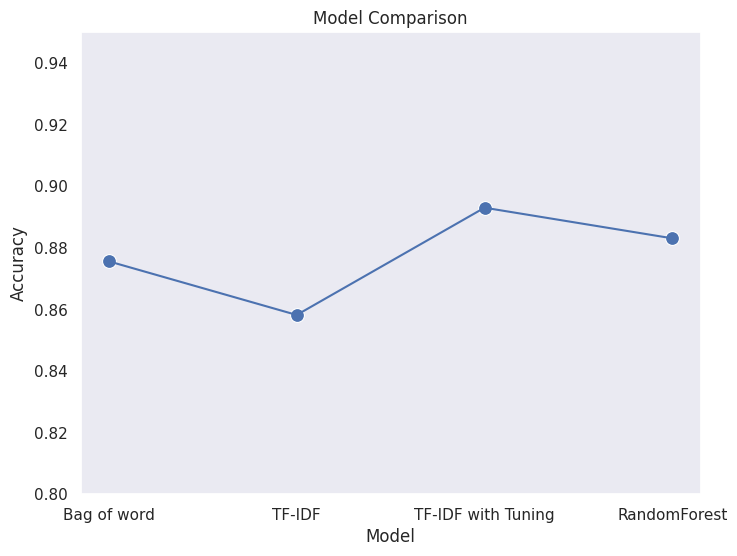

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

names = ['Bag of word', 'TF-IDF', 'TF-IDF with Tuning', 'RandomForest']
values = [0.875622, 0.858209, 0.893035, 0.883085]

plt.figure(figsize=(8, 6))
sns.scatterplot(x=names, y=values, s=100)
sns.lineplot(x=names, y=values)

plt.ylim(0.8, 0.95)
plt.xticks(rotation=0)
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Model Comparison")

# Remove grid lines
plt.grid(False)
plt.show()

### <font color=yellow>30 most common review words.</font>

In [38]:
import re

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [40]:
Finalexhaust_pd_Df.head()

,asin,overall,price,rank,reviewText,title
0,B000ECSA2E,5.0,$46.82,"["">#854,980 in Automotive (See top 100)"","">#2,...",Installed on a 2000 Civic DX. I replaced the f...,DC Sports HHC5513 Ceramic Header for Civic EX
1,B000ECSA2E,5.0,$46.82,"["">#854,980 in Automotive (See top 100)"","">#2,...","I basically love it, i chose it because of the...",DC Sports HHC5513 Ceramic Header for Civic EX
2,B000ECSA2E,5.0,$46.82,"["">#854,980 in Automotive (See top 100)"","">#2,...",sound and look good,DC Sports HHC5513 Ceramic Header for Civic EX
3,B000ECSA2E,5.0,$46.82,"["">#854,980 in Automotive (See top 100)"","">#2,...","Edit: After several thousand miles of use, the...",DC Sports HHC5513 Ceramic Header for Civic EX
4,B000ECSA2E,5.0,$46.82,"["">#854,980 in Automotive (See top 100)"","">#2,...",Used on a D16z6 and works flawlessly. Engine ...,DC Sports HHC5513 Ceramic Header for Civic EX


In [41]:
#only works under pandas. so read it using panda not spark.
#json file is in a pciture format so it needs to be converted into string before data cleanning. encoding needs to be be done.
# Create an empty list to store the cleaned tweets
cleaned_review = []

# Tidy up the tweets

for review in Finalexhaust_pd_Df['reviewText'].apply(str):
  # Remove mentions
  review = re.sub("@[\w]*","",review)
  # Remove http links
  review = re.sub("https?://[a-zA-Z0-9./]*","",review)
  # Remove special characters
  review = re.sub("[^a-zA-Z']"," ",review)
  #Remove leading and trailing whitespaces
  review = review.strip()
  #Restrict the length of the string
  if len(review) > 50:
    cleaned_review.append(review)

In [42]:
all_tw = ' '.join(cleaned_review)

myWords = word_tokenize(all_tw)

fDist = FreqDist(myWords)

fDist.most_common(30)

en_stopwords = set(stopwords.words('english'))

# Remove stop words
# Only keep words with more than 3 letters
# Lowercase the words

myWords_noSW_noCase = [word.lower() for word in myWords if (word.lower() not in en_stopwords) and (len(word)>3)]

fDist = FreqDist(myWords_noSW_noCase)

myDF = pd.DataFrame(fDist.most_common(30), columns=['word', 'frequency'])

In [ ]:
myWords

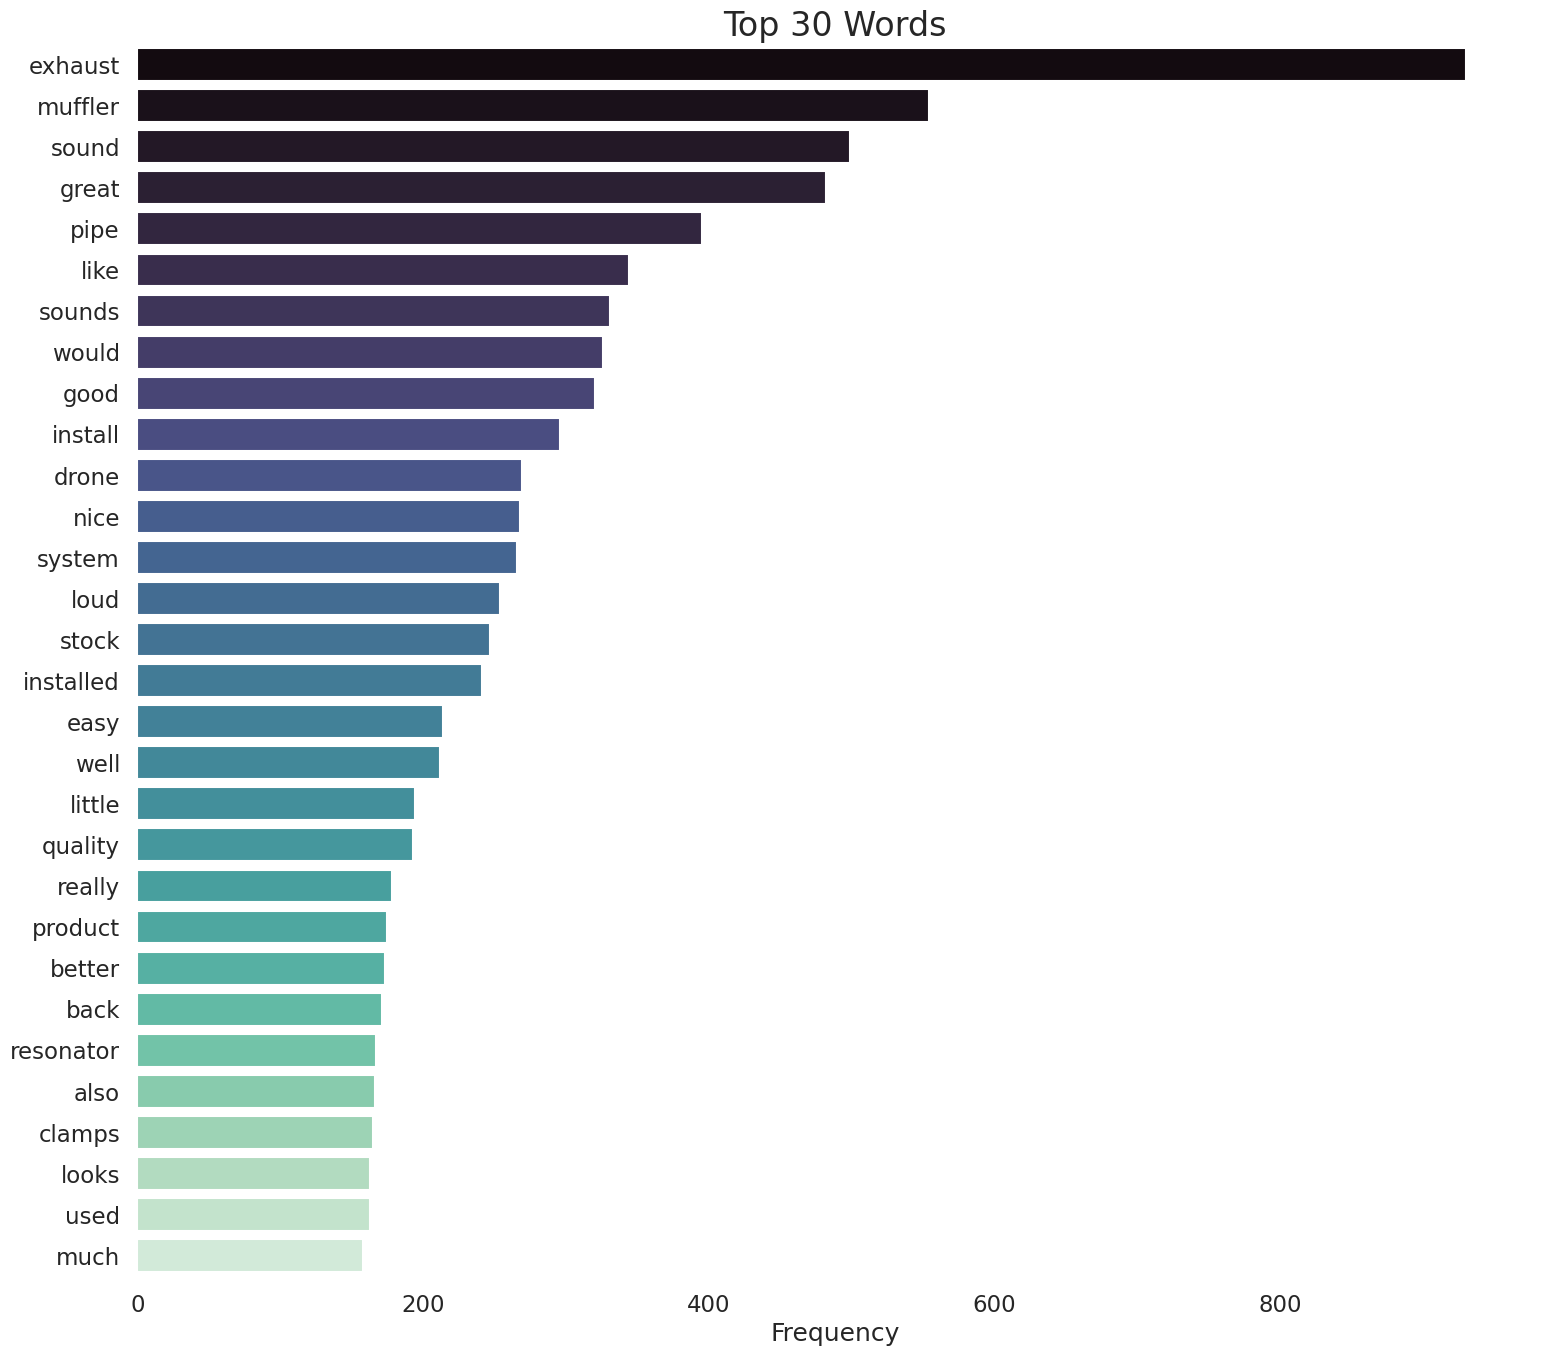

In [44]:
# Visualise the result

# Set a more specific style
sns.set_theme(style="white", context="talk")
#sns.set_theme(style="white")

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18,16))

# x and y will control if the barplot is horizontal or vertical
sns.barplot(x="frequency",
            y="word",
            data=myDF,
            palette="mako"
            )

# Add label to horiztontal axis
ax.set_xlabel("Frequency")

# Remove ylabel
ax.set_ylabel("")

# Add a title
ax.set_title("Top 30 Words", fontsize = 24)

# Remove the border line
sns.despine(left=True, bottom=True)

# Save the figure
plt.savefig("top30.png",
            bbox_inches="tight",
            dpi=200)

# Show nicely in the notebook
plt.show()

### <font color=yellow>WordCloud</font>

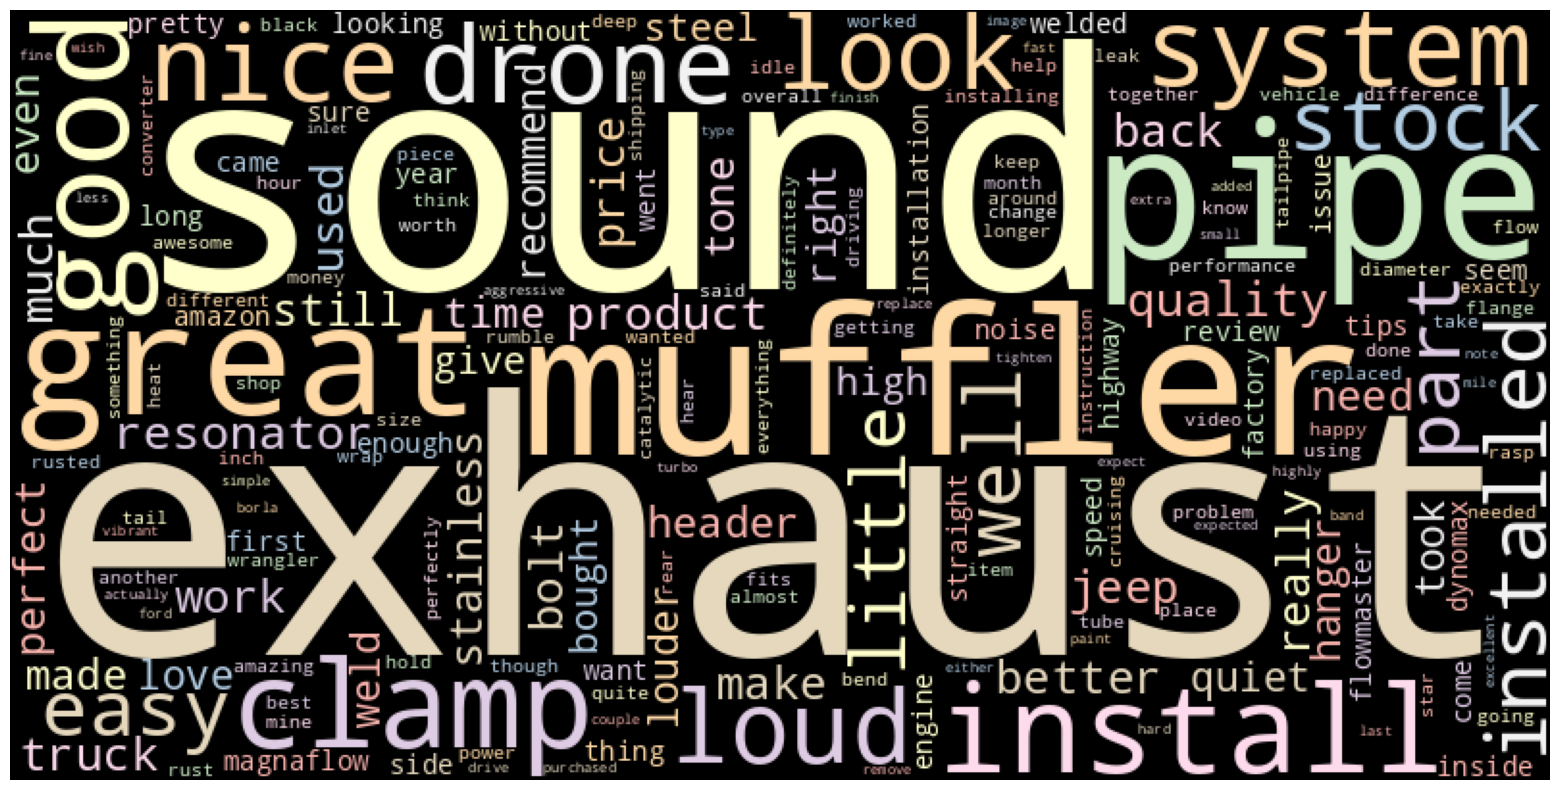

In [45]:
from wordcloud import WordCloud
myString = " ".join(myWords_noSW_noCase)
# Prepare the word cloud

myCloud = WordCloud(random_state=9165,
                    width=800, height=400,
                    # collocations=True will include 2 words/bigrams
                    collocations=False,
                    background_color='black',
                    colormap='Pastel1'
                    ).generate(myString)

# Set up the figure
plt.figure(figsize=(20,10))
plt.imshow(myCloud)
plt.axis("off")

# Save the figure
plt.savefig('wordcloud.png',
            bbox_inches='tight',
            dpi=400)

# Show nicely in the notebook
plt.show()

### <font color=yellow> Pretrained VADER sentiment classifier histogram.</font>

In [46]:
# Import the library for sentiment analysis

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [47]:
# Operate the data cleaning process on dataframe directly

# Remove mentions
Finalexhaust_pd_Df['clean_tw'] = Finalexhaust_pd_Df['reviewText'].str.replace("@[\w]*","",regex=True).apply(str)
# Remove http links
Finalexhaust_pd_Df['clean_tw'] = Finalexhaust_pd_Df['clean_tw'].str.replace("https?://[a-zA-Z0-9./]*","",regex=True)
# Remove special characters
Finalexhaust_pd_Df['clean_tw'] = Finalexhaust_pd_Df['clean_tw'].str.replace("[^a-zA-Z']"," ",regex=True)
# Remove leading and trailing whitespaces
Finalexhaust_pd_Df['clean_tw'] = Finalexhaust_pd_Df['clean_tw'].str.strip()


In [48]:
# Define some functions for convenience

def getSentScore(text):
  myScore = sia.polarity_scores(text)['compound']
  return(myScore)

def getSentCat(text):
  myScore = sia.polarity_scores(text)['compound']
  if myScore > 0.2:
    myCat = 'positive'
  elif myScore < 0.2:
    myCat = 'negative'
  else:
    myCat = 'neutral'
  return(myCat)



In [49]:
  Finalexhaust_pd_Df['sentiment_score'] = Finalexhaust_pd_Df.apply(lambda x: getSentScore(x['clean_tw']), axis=1)
  Finalexhaust_pd_Df['sentiment_cat'] = Finalexhaust_pd_Df.apply(lambda x: getSentCat(x['clean_tw']), axis=1)

In [50]:
Finalexhaust_pd_Df.head(5)

,asin,overall,price,rank,reviewText,title,clean_tw,sentiment_score,sentiment_cat
0,B000ECSA2E,5.0,$46.82,"["">#854,980 in Automotive (See top 100)"","">#2,...",Installed on a 2000 Civic DX. I replaced the f...,DC Sports HHC5513 Ceramic Header for Civic EX,Installed on a Civic DX I replaced the f...,-0.9201,negative
1,B000ECSA2E,5.0,$46.82,"["">#854,980 in Automotive (See top 100)"","">#2,...","I basically love it, i chose it because of the...",DC Sports HHC5513 Ceramic Header for Civic EX,I basically love it i chose it because of the...,0.9673,positive
2,B000ECSA2E,5.0,$46.82,"["">#854,980 in Automotive (See top 100)"","">#2,...",sound and look good,DC Sports HHC5513 Ceramic Header for Civic EX,sound and look good,0.4404,positive
3,B000ECSA2E,5.0,$46.82,"["">#854,980 in Automotive (See top 100)"","">#2,...","Edit: After several thousand miles of use, the...",DC Sports HHC5513 Ceramic Header for Civic EX,Edit After several thousand miles of use the...,0.9875,positive
4,B000ECSA2E,5.0,$46.82,"["">#854,980 in Automotive (See top 100)"","">#2,...",Used on a D16z6 and works flawlessly. Engine ...,DC Sports HHC5513 Ceramic Header for Civic EX,Used on a D z and works flawlessly Engine ...,0.2500,positive


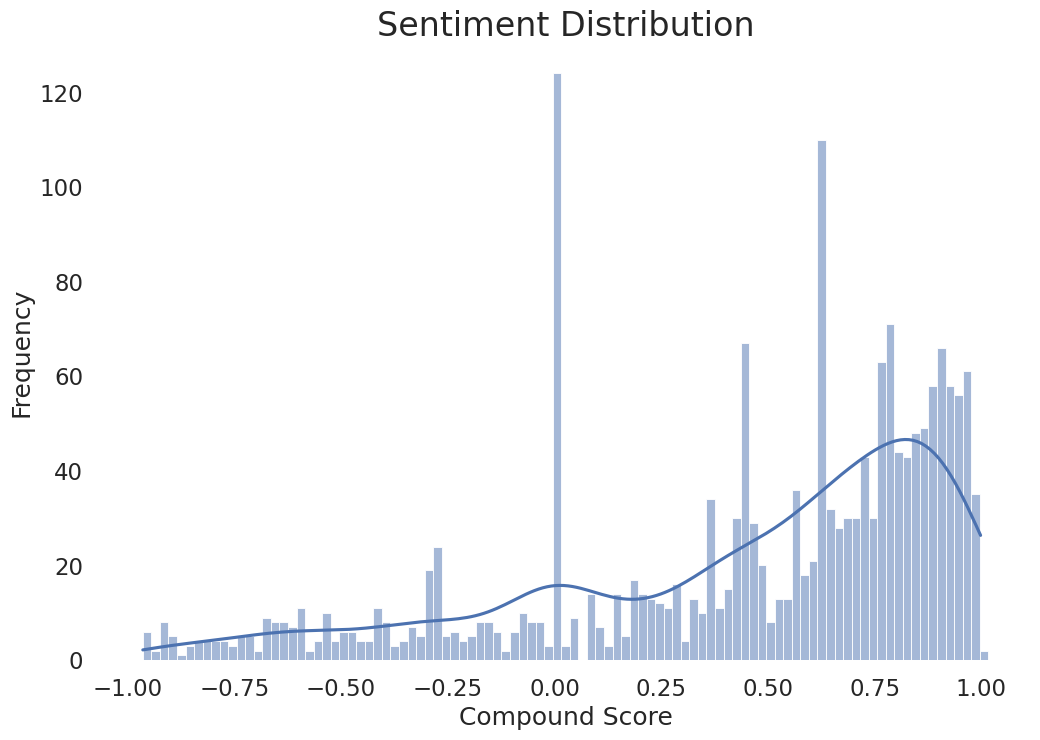

In [51]:
# Visualise the result

# Import packages
import matplotlib.pyplot as plt
import seaborn as sns

# Set a more specific style
sns.set_theme(style="white", context="talk")

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12,8))

# Use histplot
sns.histplot(x="sentiment_score",
             data=Finalexhaust_pd_Df,
             # kernal density estimation
             kde=True,
             # control the bin width
             binwidth=0.02
             )

# Add label to horiztontal axis
ax.set_xlabel("Compound Score")

# Remove ylabel
ax.set_ylabel("Frequency")

# Add a title
ax.set_title("Sentiment Distribution", fontsize = 24)

# Remove the border line
sns.despine(left=True, bottom=True)

# Save the figure
plt.savefig("sentDist.png",
            bbox_inches="tight",
            dpi=200)

# Show nicely in the notebook
plt.show()


<font color=yellow>Top 5 most reviewed Products.</font>

In [52]:
from pyspark.sql.functions import desc

In [53]:


asin_count_desc = Finalexhaust.groupBy('asin', 'title').count().orderBy(desc('count'))

asin_count_asc = Finalexhaust.groupBy('asin', 'title').count().orderBy(('count'))

In [54]:
asin_count_desc.show(truncate=False)

+----------+-------------------------------------------------------------------------------------------------------+-----+
|asin      |title                                                                                                  |count|
+----------+-------------------------------------------------------------------------------------------------------+-----+
|B001806YE2| Vibrant 1142 3&quot; Ultra Quiet Resonator                                                            |117  |
|B000BRNF68|Design Engineering 010108 Exhaust Heat Wrap, 2&quot; x 50' Roll - Black                                |100  |
|B006VOTFS2|Dynomax 39510 Super Turbo Muffler Cat-Back Dual System                                                 |79   |
|B0052XN2RI|Dynomax 36474 Stainless Steel Universal Exhaust Tip                                                    |70   |
|B000E3VHWI|Vibrant 1141 2.5&quot; Ultra Quiet Resonator                                                           |50   |
|B000ZIZCVE|Gibs

In [55]:
asin_list = ['B001806YE2', 'B000BRNF68', 'B006VOTFS2', 'B0052XN2RI', 'B000E3VHWI']
Top5Mostreviewed = myData.where(myData['asin'].isin(asin_list))

In [56]:
from pyspark.sql.functions import col

Top5Mostreviewed.select(col("reviewText")).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


<font color=yellow>Bar plot for top 5 most reviewed</font>

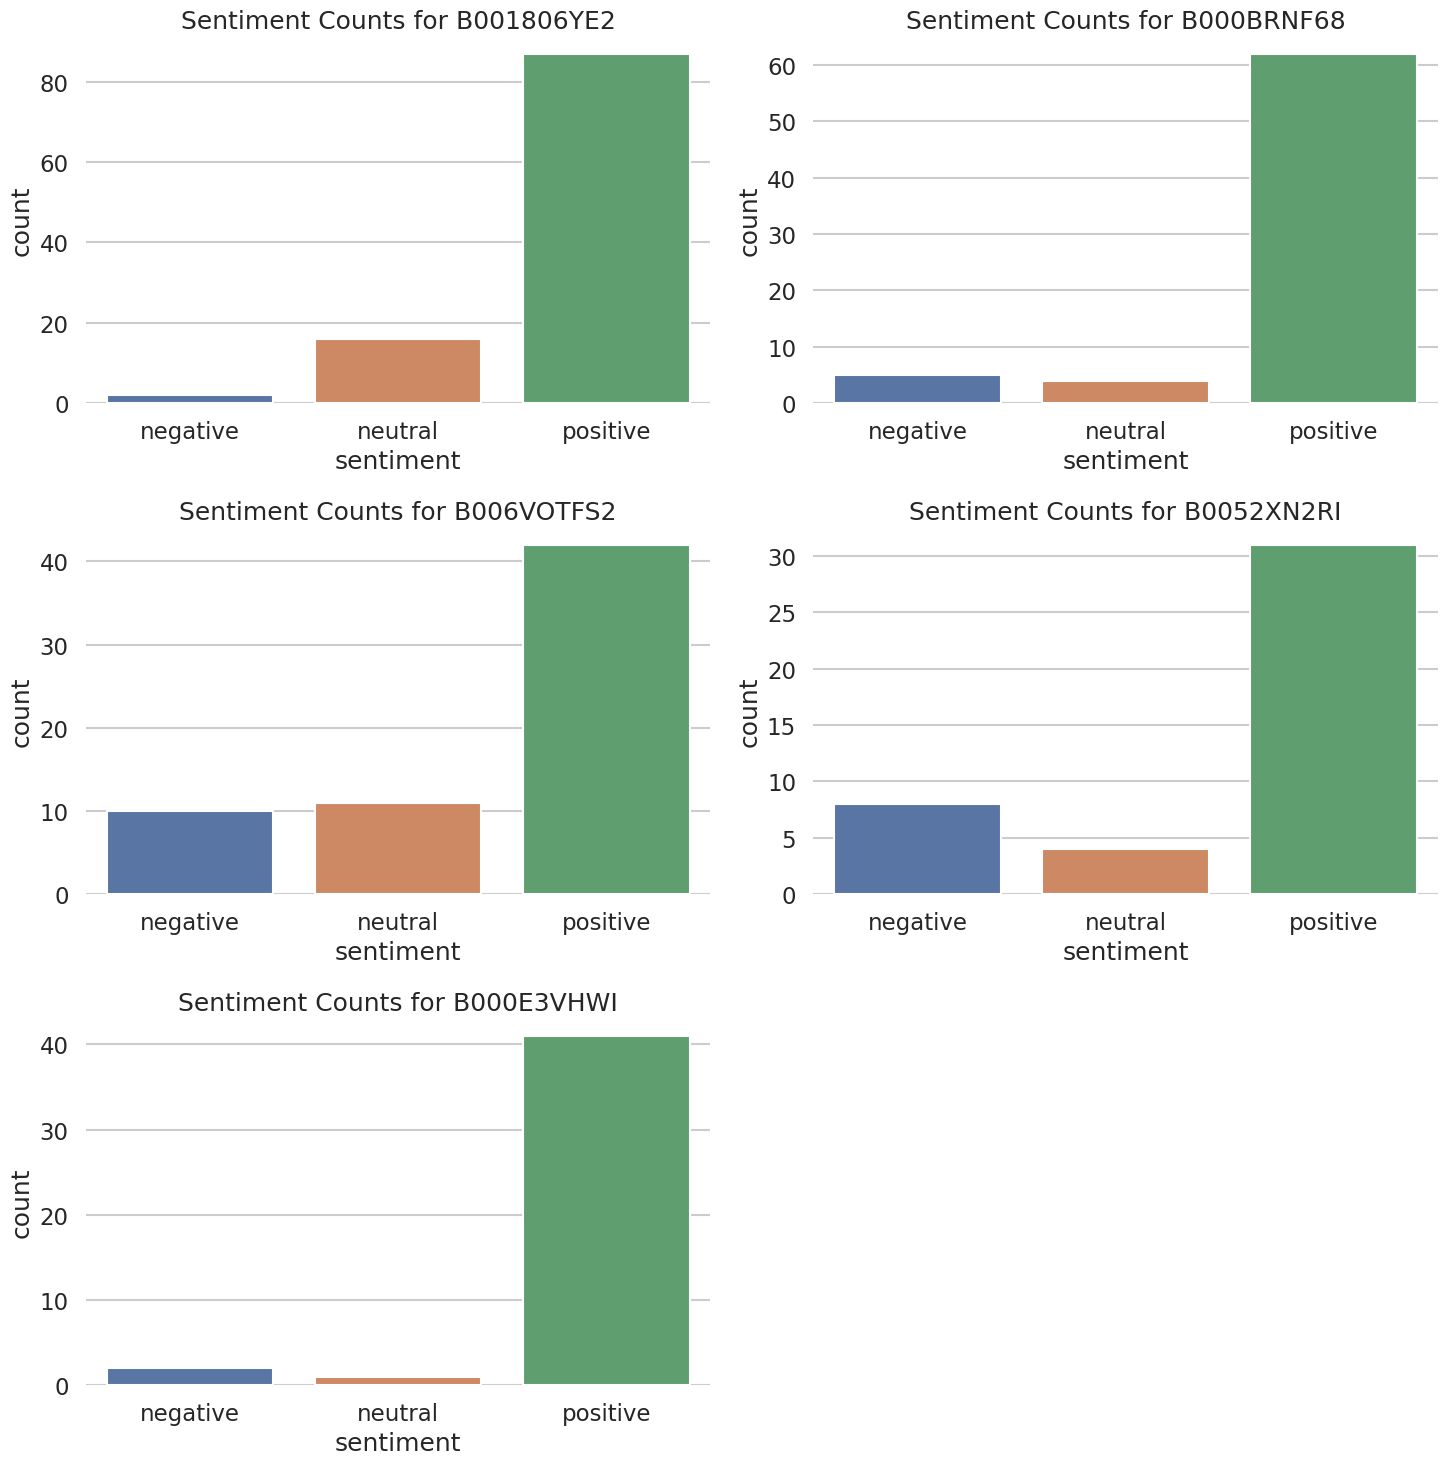

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of the plots
sns.set_style("whitegrid")

# Define the list of asin values
asin_list = ['B001806YE2', 'B000BRNF68', 'B006VOTFS2', 'B0052XN2RI', 'B000E3VHWI']

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

# Flatten the axes array for easy indexing
axes = axes.flatten()

for index, asin in enumerate(asin_list):
    # Filter the data for the current asin
    data = Top5Mostreviewed.where(Top5Mostreviewed['asin'] == asin)

    # Group the data by sentiment and count the number of reviews for each sentiment
    sentiment_counts = data.groupBy('sentiment').count().orderBy('sentiment').toPandas()

    # Create the bar chart using seaborn on the appropriate subplot
    sns.barplot(x='sentiment', y='count', data=sentiment_counts, ax=axes[index])

    sns.despine(left=True, bottom=True)

    # Set the title of the plot to the current asin value
    axes[index].set_title("Sentiment Counts for {}".format(asin))

plt.tight_layout()

# Hide the last subplot
axes[-1].axis('off')

plt.show()


Neg bigram from most reviewed

In [ ]:
Top5Mostreviewed['reviewText'] = Top5Mostreviewed['reviewText'].str.cat()

In [ ]:
# Make sure the column 'reviewText' is of string type
Top5Mostreviewed['reviewText'] = Top5Mostreviewed['reviewText'].apply(str)
# Remove special characters
Top5Mostreviewed['clean_review'] = Top5Mostreviewed['reviewText'].str.replace("[^a-zA-Z']"," ",regex=True)
# Remove leading and trailing whitespaces
Top5Mostreviewed['clean_review'] = Top5Mostreviewed['clean_review'].str.strip()

In [65]:
from pyspark.sql.functions import col, regexp_replace, trim

# Ensure the 'reviewText' column is of string type
Top5Mostreviewed = Top5Mostreviewed.withColumn('reviewText', col('reviewText').cast('string'))

# Remove special characters
Top5Mostreviewed = Top5Mostreviewed.withColumn('clean_review', regexp_replace(col('reviewText'), "[^a-zA-Z']", " "))

# Remove leading and trailing whitespaces
Top5Mostreviewed = Top5Mostreviewed.withColumn('clean_review', trim(col('clean_review')))


In [66]:
# Define some functions for convenience

def getSentScore(text):
  myScore = sia.polarity_scores(text)['compound']
  return(myScore)

  # Define some functions for convenience

def getSentCat(text):
  myScore = sia.polarity_scores(text)['compound']
  if myScore > 0:
    myCat = 'positive'
  elif myScore < 0:
    myCat = 'negative'
  else:
    myCat = 'neutral'
  return(myCat)

In [67]:
Top5Mostreviewed['sentiment_score'] = Top5Mostreviewed.apply(lambda x: getSentScore(x['clean_review']), axis=1)

AttributeError: 'DataFrame' object has no attribute 'apply'

<font color=yellow>Positive and negative word clouds for Top 5 most reviewed Products.</font>




In [68]:
Top5_pd = Top5Mostreviewed.toPandas()
type(Top5_pd)

pandas.core.frame.DataFrame

In [69]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
from nltk.corpus import stopwords

# Get English stopwords
en_stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [70]:
# Operate the data cleaning process on dataframe directly

# Make sure the column 'reviewText' is of string type
Top5_pd['reviewText'] = Top5_pd['reviewText'].apply(str)
# Remove special characters
Top5_pd['clean_review'] = Top5_pd['reviewText'].str.replace("[^a-zA-Z']"," ",regex=True)
# Remove leading and trailing whitespaces
Top5_pd['clean_review'] = Top5_pd['clean_review'].str.strip()

In [71]:
# Define some functions for convenience

def getSentCat(text):
  myScore = sia.polarity_scores(text)['compound']
  if myScore > 0:
    myCat = 'positive'
  elif myScore < 0:
    myCat = 'negative'
  else:
    myCat = 'neutral'
  return(myCat)

In [72]:
Top5_pd['sentiment_cat'] = Top5_pd.apply(lambda x: getSentCat(x['clean_review']), axis=1)

In [73]:
# Get the words for positive sentiment

# Subset the data
myDataPos = Top5_pd[Top5_pd['sentiment_cat']=='positive']
# Take the reviews
myReviewPos = myDataPos['clean_review']
# Make a single string
all_review_pos = ' '.join(myReviewPos)
# Break to words
myWordsPos = word_tokenize(all_review_pos)
# Remove stopwords and cases
myWordsPos_noSW_noCase = [word.lower() for word in myWordsPos if (word.lower() not in en_stopwords) and (len(word)>3)]
# Make a single string again for word cloud
myStringPos = " ".join(myWordsPos_noSW_noCase)

# Get the words for negative sentiment

# Subset the data
myDataNeg = Top5_pd[Top5_pd['sentiment_cat']=='negative']
# Take the reviews
myReviewNeg = myDataNeg['clean_review']
# Make a single string
all_review_neg = ' '.join(myReviewNeg)
# Break to words
myWordsNeg = word_tokenize(all_review_neg)
# Remove stopwords and cases
myWordsNeg_noSW_noCase = [word.lower() for word in myWordsNeg if (word.lower() not in en_stopwords) and (len(word)>3)]
# Make a single string again for word cloud
myStringNeg = " ".join(myWordsNeg_noSW_noCase)

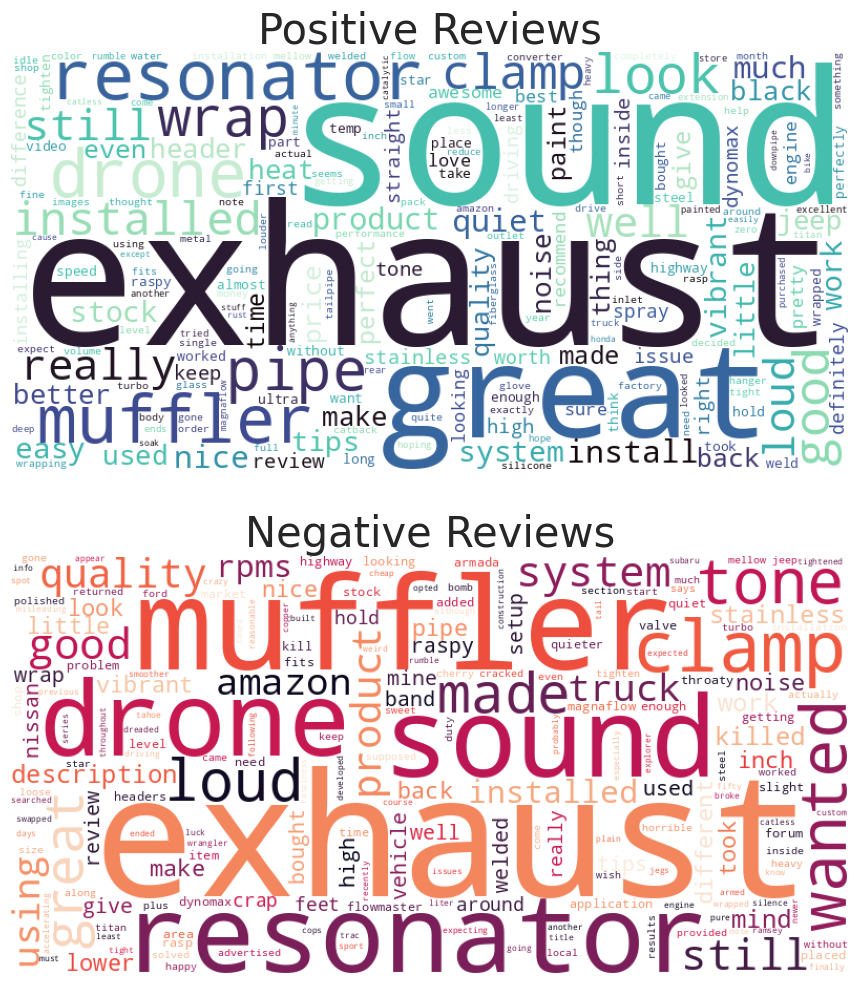

In [74]:
# Use the package wordcloud
from wordcloud import WordCloud

# Set up the matplotlib figure
f, ax = plt.subplots(2, 1,
                     figsize=(12,12)
                     )

# Generate a word cloud for postive tweets
myCloudPos = WordCloud(random_state=9165,
                       width=800, height=400,
                       # collocations=True will include 2 words/bigrams
                       collocations=False,
                       background_color='white',
                       colormap='mako'
                       ).generate(myStringPos)

ax[0].imshow(myCloudPos)
ax[0].set_title('Positive Reviews',fontsize=30)
ax[0].set_xlabel('')
ax[0].axis("off")

# Generate a word cloud for negtive tweets
myCloudNeg = WordCloud(random_state=9165,
                       width=800, height=400,
                       # collocations=True will include 2 words/bigrams
                       collocations=False,
                       background_color='white',
                       colormap='rocket'
                       ).generate(myStringNeg)

ax[1].imshow(myCloudNeg)
ax[1].set_title('Negative Reviews',fontsize=30)
ax[1].set_xlabel('')
ax[1].axis("off")

# Save the figure
plt.savefig('conditionalWordcloud.png',
            bbox_inches='tight',
            dpi=400)

# Show nicely in the notebook
plt.show()

Top products with most 5 star reviews

In [75]:
from pyspark.sql.functions import col

five_star_asin = (Finalexhaust.filter(col('overall') == 5)
                  .groupBy('asin','title')
                  .count()
                  .orderBy(col('count').desc())
                  .select('asin',  'title','count'))



In [76]:
five_star_asin.show(truncate= False)

+----------+-------------------------------------------------------------------------------------------------------+-----+
|asin      |title                                                                                                  |count|
+----------+-------------------------------------------------------------------------------------------------------+-----+
|B001806YE2| Vibrant 1142 3&quot; Ultra Quiet Resonator                                                            |87   |
|B000BRNF68|Design Engineering 010108 Exhaust Heat Wrap, 2&quot; x 50' Roll - Black                                |73   |
|B006VOTFS2|Dynomax 39510 Super Turbo Muffler Cat-Back Dual System                                                 |45   |
|B000E3VHWI|Vibrant 1141 2.5&quot; Ultra Quiet Resonator                                                           |42   |
|B0052XN2RI|Dynomax 36474 Stainless Steel Universal Exhaust Tip                                                    |32   |
|B00VA7Y5LW|Flow

<font color=yellow>Pos and Neg bigram for whole df</font>

In [77]:
import pandas as pd

# Get a bunch of tools from nltk

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.probability import FreqDist

# Import bigrams
from nltk import bigrams

# Get English stopwords
en_stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [78]:
# Make sure the column 'reviewText' is of string type
Top5_pd['reviewText'] = Top5_pd['reviewText'].apply(str)
# Remove special characters
Top5_pd['clean_review'] = Top5_pd['reviewText'].str.replace("[^a-zA-Z']"," ",regex=True)
# Remove leading and trailing whitespaces
Top5_pd['clean_review'] = Top5_pd['clean_review'].str.strip()

In [79]:
def getSentScore(text):
  myScore = sia.polarity_scores(text)['compound']
  return(myScore)

def getSentCat(text):
  myScore = sia.polarity_scores(text)['compound']
  if myScore > 0:
    myCat = 'positive'
  elif myScore < 0:
    myCat = 'negative'
  else:
    myCat = 'neutral'
  return(myCat)

In [80]:
Top5_pd['sentiment_score'] = Top5_pd.apply(lambda x: getSentScore(x['clean_review']), axis=1)

In [81]:
Top5_pd['sentiment_cat'] = Top5_pd.apply(lambda x: getSentCat(x['clean_review']), axis=1)

In [82]:
import itertools

In [91]:
# Get the words for positive sentiment

# Subset the data
myDataPos = Finalexhaust_pd_Df[Finalexhaust_pd_Df['sentiment_cat']=='positive']
# Take the reviews
myReviewPos = myDataPos['clean_tw']
# Make a single string
all_review_pos = ' '.join(myReviewPos)
# Break to words
myWordsPos = word_tokenize(all_review_pos)
# Remove stopwords and cases
myWordsPos_noSW_noCase = [word.lower() for word in myWordsPos if (word.lower() not in en_stopwords) and (len(word)>3)]

# Count word frequency with the cleaned set
fDistPos = FreqDist(myWordsPos_noSW_noCase)

# Convert the result to a dataframe for visualisation
myDFPos = pd.DataFrame(fDistPos.most_common(30), columns=['word', 'frequency'])

# Make a single string again for word cloud
myStringPos = " ".join(myWordsPos_noSW_noCase)

# Generate lists of bigrams for network visualisation
myTokensPos = [word_tokenize(tweet) for tweet in myDataPos['clean_tw']]
myTokensPos_noSW_noCase = [[word.lower() for word in tweet if (word.lower() not in en_stopwords) and (len(word)>3)] for tweet in myTokensPos]
myBigramPos = [list(bigrams(tweet)) for tweet in myTokensPos_noSW_noCase]
myBigramListPos = list(itertools.chain.from_iterable(myBigramPos))
bigramFreqPos = FreqDist(myBigramListPos)

In [84]:
# Get the words for negative sentiment

# Subset the data
myDataNeg = Top5_pd[Top5_pd['sentiment_cat']=='negative']
# Take the reviews
myReviewNeg = myDataNeg['clean_review']
# Make a single string
all_review_neg = ' '.join(myReviewNeg)
# Break to words
myWordsNeg = word_tokenize(all_review_neg)
# Remove stopwords and cases
myWordsNeg_noSW_noCase = [word.lower() for word in myWordsNeg if (word.lower() not in en_stopwords) and (len(word)>3)]

# Count word frequency with the cleaned set
fDistNeg = FreqDist(myWordsNeg_noSW_noCase)

# Convert the result to a dataframe for visualisation
myDFNeg = pd.DataFrame(fDistNeg.most_common(30), columns=['word', 'frequency'])

# Make a single string again for word cloud
myStringNeg = " ".join(myWordsNeg_noSW_noCase)

# Generate lists of bigrams for network visualisation
myTokensNeg = [word_tokenize(tweet) for tweet in myDataNeg['clean_review']]
myTokensNeg_noSW_noCase = [[word.lower() for word in tweet if (word.lower() not in en_stopwords) and (len(word)>3)] for tweet in myTokensNeg]
myBigramNeg = [list(bigrams(tweet)) for tweet in myTokensNeg_noSW_noCase]
myBigramListNeg = list(itertools.chain.from_iterable(myBigramNeg))
bigramFreqNeg = FreqDist(myBigramListNeg)

In [93]:
# Prepare the bigram network

# We need networkx
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt

myResultPos = bigramFreqPos.most_common(50)

# Construct the network
G_pos = nx.DiGraph()
# Create connections between nodes
for i in myResultPos:
    G_pos.add_edge(i[0][0], i[0][1], weight=(i[1]))

# For negative reviews

# Collect the result
myResultNeg = bigramFreqNeg.most_common(50)
# Construct the network
G_neg = nx.DiGraph()
# Create connections between nodes
for i in myResultNeg:
    G_neg.add_edge(i[0][0], i[0][1], weight=(i[1]))

<ipython-input-95-22684dd64e20>:11: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which has known issues and is not actively maintained. Consider using nx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos_pos = graphviz_layout(G_pos, prog="neato")
<ipython-input-95-22684dd64e20>:34: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which has known issues and is not actively maintained. Consider using nx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos_neg = graphviz_layout(G_neg, prog="neato")


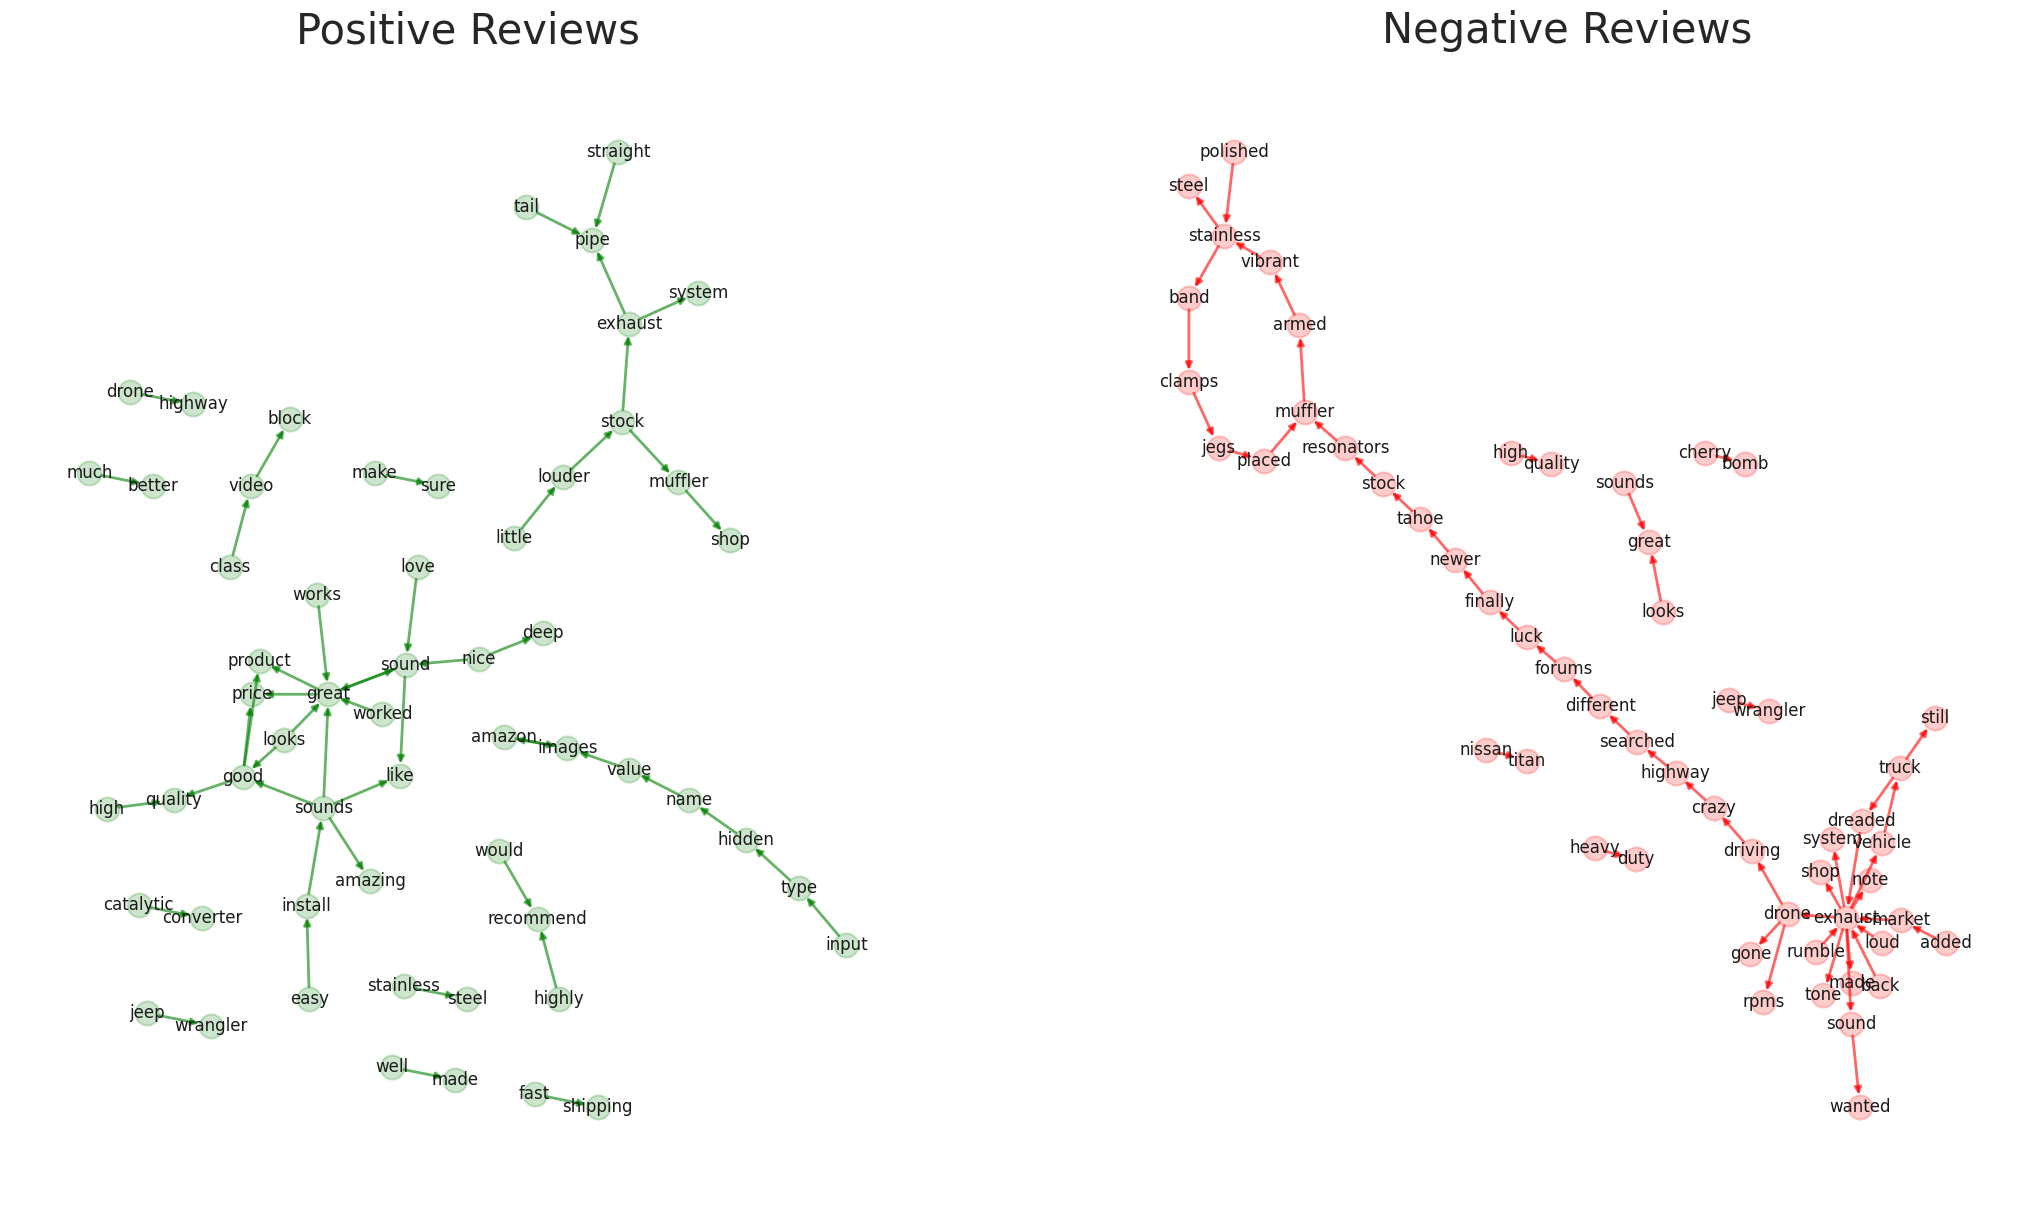

In [95]:
# Visualisation
f, ax = plt.subplots(1,2,figsize=(26, 15))

# For positive subplot

# use another layout
pos_pos = graphviz_layout(G_pos, prog="neato")

# store the node label information
labels_pos = {}
for node in G_pos.nodes:
    labels_pos[node] = node

# Plot edges
nx.draw_networkx_edges(G_pos, pos_pos, width=2, alpha=0.6, edge_color="green", ax=ax[0])

# Plot nodes
nx.draw_networkx_nodes(G_pos, pos_pos, alpha=0.2, label=True, node_color="green", ax=ax[0])

# Add labels
nx.draw_networkx_labels(G_pos, pos_pos, labels_pos, ax=ax[0])

# Turn off the axis
ax[0].axis("off")
ax[0].set_title('Positive Reviews',fontsize=30)

# For negative subplot

# use another layout
pos_neg = graphviz_layout(G_neg, prog="neato")

# store the node label information
labels_neg = {}
for node in G_neg.nodes:
    labels_neg[node] = node

# Plot edges
nx.draw_networkx_edges(G_neg, pos_neg, width=2, alpha=0.6, edge_color="red", ax=ax[1])

# Plot nodes
nx.draw_networkx_nodes(G_neg, pos_neg, alpha=0.2, label=True, node_color="red", ax=ax[1])

# Add labels
nx.draw_networkx_labels(G_neg, pos_neg, labels_neg, ax=ax[1])

# Turn off the axis
ax[1].axis("off")
ax[1].set_title('Negative Reviews',fontsize=30)

# Save the figure
plt.savefig('directedBigram.png',
            bbox_inches='tight',
            dpi=400)

# Show nicely in the notebook
plt.show()